# Strojno i duboko učenje  - Autoenkoderi

Korišteno: https://github.com/ageron/handson-ml2/blob/master/17_autoencoders_and_gans.ipynb

**Autoenkoderi (eng.Autoencoders)** se satoje od dvije mreže:

* Enkoder
* Dekoder

***Enkoder*** prima ulazne podatke (npr. slike, video) i komprimira ih u latentni vektor, dok ***dekoder*** taj vektor dekompresira nazad u originalne podatke.




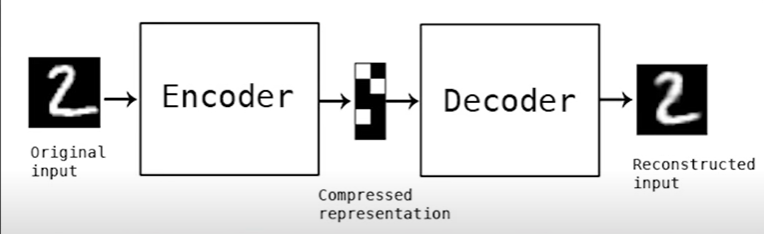

Autoenkoderi uvijek imaju manje ulaznih neurona u srednjem sloju nego u ulaznom i izlaznom sloju. To se naziva usko grlo **bottleneck**. Da nije tog uskog grla, autoenkoderi bi jednostavno mogli kopiratipodatke s ulaznog na izlazni sloj bez komprimiranja.


Da bi se maksimizirala performansa i minimizirao gubitak, enkoderi i dekoderi su obično simetrični, odnosno **veličina ulaza jednaka je veličini izlaza** autoenkodera.

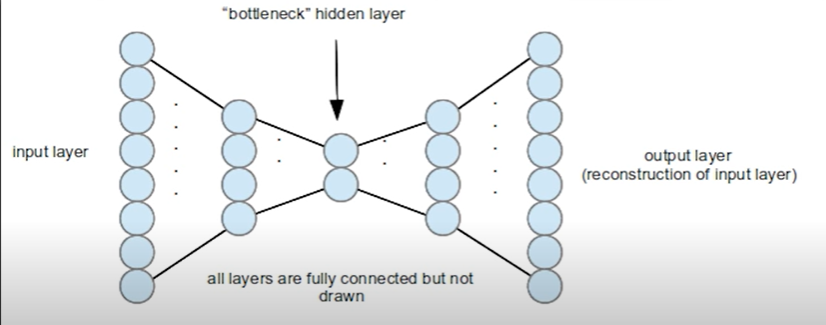

Primjena:
* **Kompresija podataka**: Autoenkoderi se koriste za kompresiju podataka, poput slika, zvuka ili videa, kako bi se smanjila veličina datoteke, olakšalo skladištenje i prijenos podataka.

* **Rekonstrukcija slika:** Koriste se za rekonstrukciju oštećenih ili mutnih slika te za uklanjanje šuma iz slika.

* **Generiranje sadržaja:** Autoenkoderi se mogu koristiti za generiranje novih slika, zvukova ili teksta. Primjerice, mogu generirati realistične slike ljudi ili pejzaža.

* Detekcija anomalija, Prepoznavanje značajki, Smanjenje dimenzionalnosti,...

##Jednostavan autoenkoder

###Učitavanje podataka

In [ ]:
import tensorflow
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()

In [ ]:
x_train = x_train / 255
x_test = x_test / 255

###Definiranje enkodera i dekodera

In [ ]:
encoder=keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28,28]),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(30, activation="relu")   #bottleneck
])

In [ ]:
decoder=keras.models.Sequential([
    keras.layers.Dense(100, activation="relu",input_shape=[30]),
    keras.layers.Dense(28*28, activation="sigmoid"),
    keras.layers.Reshape([28,28])
])

###Spajanje dvije mreže u autoenkoder

Enkoderi i dekoderi se mogu trenirati odvojeno, ali obično se treniraju zajedno (**eng. stacked autoencoder).**

In [ ]:
stacked_autoencoder=keras.models.Sequential([encoder,decoder])

###Treniranje modela

In [ ]:
stacked_autoencoder.compile(loss="binary_crossentropy", optimizer='adam', metrics=['accuracy'])

In [ ]:
history=stacked_autoencoder.fit(x_train,x_train, epochs=10,validation_data=[x_test,x_test])

###Prikaz rezultata

In [ ]:
plt.figure(figsize=(20,5))

for i in range(8):
  plt.subplot(2,8,i+1)
  plt.imshow(x_test[i], cmap="binary")

  plt.subplot(2,8,8+1+i)
  pred=stacked_autoencoder.predict(x_test[i].reshape(1,28,28))
  plt.imshow(pred.reshape(28,28),cmap="binary")

In [ ]:
plt.figure(figsize=(10,5))

plt.subplot(1,3,1)
plt.imshow(x_test[0], cmap="binary")

plt.subplot(1,3,2)
latent_vector=encoder.predict(x_test[0].reshape(1,28,28))
plt.imshow(latent_vector, cmap="binary")

plt.subplot(1,3,3)
pred=decoder.predict(latent_vector)
plt.imshow(pred.reshape(28,28),cmap="binary")

In [ ]:
1-30/(28*28)

## Uklanjanje šuma (eng. noise)

In [ ]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.imshow(x_test[0], cmap="binary")

plt.subplot(1,2,2)
noise=np.random.random((28,28))/4
plt.imshow(x_test[0]+noise, cmap="binary")

In [ ]:
encoder=keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28,28]),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(100, activation="relu"), ######
    keras.layers.Dense(30, activation="relu")   #bottleneck
])

In [ ]:
decoder=keras.models.Sequential([
    keras.layers.Dense(100, activation="relu",input_shape=[30]),
    keras.layers.Dense(100, activation="relu"),#####
    keras.layers.Dense(28*28, activation="sigmoid"),
    keras.layers.Reshape([28,28])
])

In [ ]:
stacked_autoencoder=keras.models.Sequential([encoder,decoder])

In [ ]:
stacked_autoencoder.compile(loss="binary_crossentropy", optimizer='adam', metrics=['accuracy'])

In [ ]:
#dodavanje šuma
x_train_noise=x_train+((np.random.random(x_train.shape))/4)
x_test_noise=x_test+((np.random.random(x_test.shape))/4)

In [ ]:
history=stacked_autoencoder.fit(x_train_noise,x_train, epochs=10,validation_data=[x_test_noise,x_test])

In [ ]:
plt.figure(figsize=(20,5))

for i in range(8):
  plt.subplot(2,8,i+1)
  plt.imshow(x_test_noise[i], cmap="binary")

  plt.subplot(2,8,8+1+i)
  pred=stacked_autoencoder.predict(x_test_noise[i].reshape(1,28,28))
  plt.imshow(pred.reshape(28,28),cmap="binary")

## Convolutional autoencoder

Apart from data compression, autoencoders can also be used for self-supervised image classification.

The first layers of the encoder learn to recognize patterns in the data very well in order to compress the data. If you don't have access to much labelled data, but a lot of unlabelled data, it's possible to train an autoencoder and copy the first layers from the autoencoder to the classifier network. This can be compared to transfer learning, where you only have to train the head afterwards.

It is well known that convolutional layers are perfect for finding patterns in data, so it's good to know they can also be used in autoencoders. To "de-convolve" images in the decoder, transposed convolutional layers are used. For more information on transposed convolutional layers, checkout [this blog post](https://rickwierenga.com/blog/s4tf/s4tf-gan.html) I have written which explains them in more detail. See the last section "Autoencoders and GANs" of this notebook for more information on the beautiful relation between GANs and autoencoders.

Let's look at a convolutional encoder:

In [ ]:
encoder = keras.models.Sequential([
    keras.layers.Reshape([28, 28, 1], input_shape=[28, 28]),
    keras.layers.Conv2D(16, kernel_size=(3, 3), padding="same", activation="relu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(32, kernel_size=(3, 3), padding="same", activation="relu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(64, kernel_size=(3, 3), padding="same", activation="relu"),
    keras.layers.MaxPool2D(pool_size=2)
])

The weights learnt by this encoder could be copied to the classifier.

In [ ]:
encoder.predict(x_test[0].reshape((1, 28, 28))).shape   #ovo nam treba za input shape napisat 1 je uspred jer je samo za jednu sliku tu gledano

Notice how $z \in \mathbb{R}^{1 \times 3 \times 3 \times 64}$. Now we build its counterpart, the decoder, with transposed convolutional layers to recreate a grayscale $28 \times 28$ image.

In [ ]:
decoder = keras.models.Sequential([
    keras.layers.Conv2DTranspose(32, kernel_size=(3, 3), strides=2, padding="valid",
                                 activation="relu",
                                 input_shape=[3, 3, 64]),
    keras.layers.Conv2DTranspose(16, kernel_size=(3, 3), strides=2, padding="same",
                                 activation="relu"),
    keras.layers.Conv2DTranspose(1, kernel_size=(3, 3), strides=2, padding="same",
                                 activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])

In [ ]:
stacked_autoencoder = keras.models.Sequential([encoder, decoder])

In [ ]:
stacked_autoencoder.compile(loss="binary_crossentropy",
                            optimizer='adam', metrics=['accuracy'])

In [ ]:
history = stacked_autoencoder.fit(x_train, x_train, epochs=5,   #stavi 10
                         validation_data=[x_test, x_test])

In [ ]:
plt.figure(figsize=(20, 5))
for i in range(8):
  plt.subplot(2, 8, i+1)
  pred = stacked_autoencoder.predict(x_test[i].reshape((1, 28, 28)))
  plt.imshow(x_test[i], cmap="binary")

  plt.subplot(2, 8, i+8+1)
  plt.imshow(pred.reshape((28, 28)), cmap="binary")

Let's look at the weights the encoder learnt. Note that $\sqrt{64} = 8$.

In [ ]:
plt.figure(figsize=(15,15))
for i in range(8 * 8):
  plt.subplot(8, 8, i+1)
  plt.imshow(encoder.layers[-2].weights[0][:, :, 0, i])

Visually not very pleasing, but proven to be effective as shown in the previous figure.

$3 \times 3 \times 64=576$ is still less than $28 \times 28 = 784$, thus creating a bottleneck, but much less compressed than the dense encoder making convolutional encoders less suitable for comporession. But thanks to their convolutional layers, they are great to use in cases where you want your autoencoder to find visual patterns in your data.

## Autoencoders and GANs

If you have ever worked with GANs, you have probably noticed some similarities between the generator and decoders by now. Both create images that look like images in the dataset from latent vectors. In fact, the decoder we used for the convolutional auto encoder is one that could be used in DCGANs ([ref](https://rickwierenga.com/blog/s4tf/s4tf-gan.html)).

By encoding training images into latent vectors using an encoder, it's possible to manipulate the output of the generator by manipulating the latent vectors.

* Combining latent vectors of particular training examples into a single latent vector to combine the features of the training examples in a single image.
* That's what researchers at NVIDIA built upon by transitioning latent vectors it's possible to create videos like these:

https://www.youtube.com/watch?v=6E1_dgYlifc